1. [Descrición del proyecto](#ddp)
2. [Inicialización](#in)
3. [Preparación de datos](#pdd)
    - 3.1 [Carga del set de datos](#cdsdd)
    - 3.2 [Preprocesamientos de datos](#predd)
    - 3.3 [Nombres de cadenas comerciales](#ndcc)
    - 3.4 [Separar las calles de la direccion](#slcdld)
    
4. [Analisís de datos](#add)
    - 4.1 [Proporciones de los distintos tipos de establecimientos](#pdldtde)
    - 4.2 [Proporciones de los distintos tipos de establecimintos que pertenecen a una cadena](#pdldtdeqpauc)
    - 4.3 [Tipos de establecimientos que es habitualmente una cadena](#tdeqehuc)
    - 4.4 [Promedio de asientos para cada tipo de establecimientos](#pdapctde)
    - 4.5 [Diez mejores calles por número de establecimientos](#dmcpnde)
    - 4.6 [Calles que tienen un solo establacimiento](#cqtuse)
    - 4.7 [Distribución del número de asientos para las calles con muchos establecimientos](#ddndaplccme)
    - 4.8 [Las cafeterias en las diez calles con mas establecimientos](#lceldccme)
5. [Conclusión](#ccs)
6. [Link de presentacion](#link)
   

## Descripón del proyecto.<a id='ddp'></a>

En este proyecto evaluaremos un estudio de mercado para un nuevo emprendimiento un café atendido por robots en Los Angeles, y siendo un empredimiento muy prometedor necesitamos saber si el nuevo café podra ser capaz de mantener un exito cuando la novedad de los camareros robots desaparezca.
Necesitamos atraer inversionistas para este nuevo empredimiento asi que procederemos con un exhaustivo analisís con los datos que obtuvimos de fuentes abiertas sobre los restaurantes en Los Angeles.

## Inicialización.<a id='in'></a>

Vamos a cargar las librerias que vamos a utilizar.

In [1]:
!pip install usaddress

     |████████████████████████████████| 63 kB 3.7 MB/s  eta 0:00:01
     |████████████████████████████████| 840 kB 33.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 60.3 MB/s eta 0:00:01
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492026 sha256=fa1fcabab84c9a3cfca97611202e8f996a5eb125ac25e5c64a7961d4a3488c80
  Stored in directory: /home/jovyan/.cache/pip/wheels/bf/5d/6a/2e53874f7ec4e2bede522385439531fafec8fafe005b5c3d1b
Successfully built future


In [2]:
# Cargaremos las librerias necesarias.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from usaddress import STREET_NAMES, DIRECTIONS
import usaddress
import re
import difflib

sns.set_palette(palette='tab10')

## Preparacón de datos. <a id='pdd'></a>

### Carga del set de datos. <a id='cdsdd'></a>

In [3]:
# descargaremos los datos, asegurando que las columnas esten con el tipo correcto.
rest_data = pd.read_csv('/datasets/rest_data_us.csv', dtype={'chain':'boolean', 'object_type':'category'})

In [4]:
# Veamos la información de los datos, y si existen datos duplicados.
rest_data.info()
print()
print(f'Datos duplicados: {rest_data.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           9651 non-null   int64   
 1   object_name  9651 non-null   object  
 2   address      9651 non-null   object  
 3   chain        9648 non-null   boolean 
 4   object_type  9651 non-null   category
 5   number       9651 non-null   int64   
dtypes: boolean(1), category(1), int64(2), object(2)
memory usage: 330.2+ KB

Datos duplicados: 0


In [5]:
# veamos una información general.
rest_data.head()

,id,object_name,address,chain,object_type,number
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20


La tabla de datos contiene la siguiente información.
- `id:` - Identificador.
- `objct_name:` - Nombre del establecimiento.
- `chain:` - Establecimiento que pertenece a una cadena .
- `object_type:` - Tipo de establecimiento.
- `address:` - Direccion.
- `number:` - Número de asientos.

- Logramos identificar que nuesta tabla consta de 6 columnas y 9651 filas.
- Nuestra tabla contiene 3 valores ausentes en la columna chain y no tiene valores duplicados.
- Los tipos de la columnas estan en orden.

### Preprocesamientos de datos.<a id='predd'></a>

In [6]:
# nos aseguramos que el contendido del dataframe este en mayúsculas para homogeneizar el contenido
rest_data['object_name'] = rest_data['object_name'].str.upper()
rest_data['address'] = rest_data['address'].str.upper()
rest_data['object_type'] = rest_data['object_type'].str.upper()

In [7]:
# revisemos los valores ausentes.
rest_data.isna().sum()

id             0
object_name    0
address        0
chain          3
object_type    0
number         0
dtype: int64

In [8]:
# buscaremos los valores nulos.
isna_list_chain = rest_data[rest_data['chain'].isna()]['object_name']
isna_list_chain

7408    TAQUERIA LOS 3 CARNALES
7523       JAMMIN JIMMY'S PIZZA
8648      THE LEXINGTON THEATER
Name: object_name, dtype: object

In [9]:
# creamos el dataframe con los nombres de establecimientos en la lista creada anteriormente
rest_data[rest_data['object_name'].isin(isna_list_chain)]

,id,object_name,address,chain,object_type,number
7408,19194,TAQUERIA LOS 3 CARNALES,5000 E WHITTIER BLVD,<NA>,RESTAURANT,14
7523,19309,JAMMIN JIMMY'S PIZZA,1641 FIRESTONE BLVD,<NA>,PIZZA,1
8648,20434,THE LEXINGTON THEATER,129 E 3RD ST,<NA>,RESTAURANT,35


In [10]:
# buscamos 'CARNALES', 'LEXINGTON' y 'JAMMIN' en el set de datos\n",
rest_data[(rest_data['object_name'].str.contains('CARNALES'))\
                | (rest_data['object_name'].str.contains('LEXINGTON'))\
                | (rest_data['object_name'].str.contains('JAMMIN'))]

,id,object_name,address,chain,object_type,number
6419,18205,TACOS LOS CARNALES,4370 S CENTRAL AVE,False,FAST FOOD,47
6624,18410,TACOS LOS 3 CARNALES,5000 WHITTIER BLVD,False,FAST FOOD,6
6790,18576,WI JAMMIN CAFE,1359 S REDONDO BLVD,False,RESTAURANT,28
7408,19194,TAQUERIA LOS 3 CARNALES,5000 E WHITTIER BLVD,<NA>,RESTAURANT,14
7523,19309,JAMMIN JIMMY'S PIZZA,1641 FIRESTONE BLVD,<NA>,PIZZA,1
8648,20434,THE LEXINGTON THEATER,129 E 3RD ST,<NA>,RESTAURANT,35
9616,21402,TACOS LOS 4 CARNALES,5000 WHITTIER BLVD,False,FAST FOOD,9


In [11]:
# vamos a remplazar los valores ausentes en la columna chain con false
rest_data['chain'].fillna(False, inplace=True)
rest_data.isna().sum()

id             0
object_name    0
address        0
chain          0
object_type    0
number         0
dtype: int64

In [12]:
# reemplazamos los valores en la columna chain para una mejor comprensión 
rest_data['chain'].replace({False:'No pertenece', True:'Pertenece'},inplace=True)
rest_data.head()

,id,object_name,address,chain,object_type,number
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,No pertenece,CAFE,26
1,11787,REILLY'S,100 WORLD WAY # 120,No pertenece,RESTAURANT,9
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,No pertenece,FAST FOOD,20
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,No pertenece,RESTAURANT,22
4,11790,POLLEN,2100 ECHO PARK AVE,No pertenece,RESTAURANT,20


In [13]:
print(f'datos duplicados: {rest_data.duplicated().sum()}')

datos duplicados: 0


**Conclusión intermedia**
- Cambiamos los datos de las columnas de minusculas a mayusculas para un mejor manejo de los datos.
- Remplazamos los valores ausentes por False ya que en una exploracion los comercios con el mismo nombre pertenecian a false.
- Cambiamos los valores de la columna chain de **False a No pertenece y de True a pertenece** para una mejor compresión de los valores.


### Nombres de cadenas comerciales. <a id='ndcc'></a>

In [14]:
# Definamos una función para extraer el nombre de un establecimiento que pueda pertenecer a una cadena
def extraer_name_chain(object_name):
  
    name = object_name
    
# eliminemos los digitos y los numerales al inicio y final del texto
    patron = re.compile(r'#\d+|#\s\d+|#\w+\d+\-\d+')
    texto_limpio = patron.sub('', name)
    
# vamos a reemplazar 'CO.' por 'COMPANY'
    patron = re.compile(r'COMPANY')
    texto_limpio_2 = patron.sub('CO.', texto_limpio)
    
# vamos a reemplazar 'INCORPORATION' por 'INC.'
    patron = re.compile(r'INCORPORATION')
    texto_limpio_3 = patron.sub('INC.', texto_limpio_2).strip()
    
    return texto_limpio_3

In [15]:
# aplicamos la funcion para extraer el 'name_chain' de los establecimientos
rest_data['name_chain'] = rest_data['object_name'].apply(extraer_name_chain)

In [16]:
# veamos los datos.
rest_data.head(5)

,id,object_name,address,chain,object_type,number,name_chain
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,No pertenece,CAFE,26,HABITAT COFFEE SHOP
1,11787,REILLY'S,100 WORLD WAY # 120,No pertenece,RESTAURANT,9,REILLY'S
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,No pertenece,FAST FOOD,20,STREET CHURROS
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,No pertenece,RESTAURANT,22,TRINITI ECHO PARK
4,11790,POLLEN,2100 ECHO PARK AVE,No pertenece,RESTAURANT,20,POLLEN


In [17]:
# consideremos la siguiente agrupacion para 'STARBUCKS'
rest_data[rest_data['object_name'].str.contains("STARBUCKS")][['chain','name_chain']].value_counts()

chain      name_chain                           
Pertenece  STARBUCKS COFFEE                         87
           STARBUCKS                                30
           STARBUCKS EVENING                         2
           STARBUCKS  @ USC                          1
           STARBUCKS (COFFEE BAR) LEVEL 1 - UCLA     1
           STARBUCKS -  DEPARTURE                    1
           STARBUCKS - ARRIVAL                       1
           STARBUCKS 22477                           1
           STARBUCKS CAFE 84                         1
           STARBUCKS COFFEE CORPORATION              1
           STARBUCKS STORE                           1
           STARBUCKS-17413                           1
           STARBUCKS/LA CAFE                         1
dtype: int64

In [18]:
# encontremos la similitud entre las palabras usando la libreria 'difflib'
difflib.get_close_matches('STARBUCKS 22477', ['STARBUCKS COFFEE', 'STARBUCKS',"ANDY'S BAKERY"],cutoff=0.7)

['STARBUCKS']

In [19]:
# encontremos la similitud entre las palabras usando la libreria 'difflib'
difflib.get_close_matches('STARBUCKS CAFE 84', ['STARBUCKS COFFEE', 'STARBUCKS',"ANDY'S BAKERY",'TACO BELL'],cutoff=0.5)

['STARBUCKS COFFEE', 'STARBUCKS']

In [20]:
# consideremos la siguiente agrupacion de establecimientos que pertenecen a una cadena
rest_data[rest_data['chain'] == 'Pertenece']['name_chain'].value_counts()

SUBWAY                        113
STARBUCKS COFFEE               87
MCDONALD'S                     79
JACK IN THE BOX                52
THE COFFEE BEAN & TEA LEAF     51
                             ... 
CAFFE DELIZIOSO                 1
BOTTLE ROCK                     1
FAT BURGER                      1
WABA GRILL, LLC                 1
PIZZA MAN 8                     1
Name: name_chain, Length: 2102, dtype: int64

In [21]:
# contamos las veces que se repite el nombre de un establecimiento y mostramos percentiles para este conteo
data = rest_data['name_chain'].value_counts()
np.percentile(data,[50,90,95,97,99,99.5])

array([1., 1., 2., 2., 4., 8.])

In [22]:
# creamos una lista con los nombres de establecimiento que se repiten 8 ó mas veces
repeat_name = [data.index[i] for i in range(len(data)) if data[i]>=8]

In [23]:
# Creamos una columna con el nombre de los establecimientos definitivos, aquellos que pertenecen a una cadena
def name_rest(name_chain):
    
# comparamos cada valor de la columna 'extraer_name_chain' con los valores de la lista 'repeat_name' y encontrar similitudes
    try:
        name = difflib.get_close_matches(name_chain, repeat_name, cutoff = 0.8)[0]
        return name
    except:
        return name_chain

In [24]:
# aplicamos la funcion para crear el name_restde los establecimientos
rest_data['restaurant'] = rest_data['name_chain'].apply(name_rest)

In [25]:
# eliminamos la columna 'pre_name_chain'
rest_data.drop('name_chain', inplace=True, axis=1)

In [26]:
# mostramos parte de los datos
rest_data[rest_data['restaurant'].str.contains('STARBUCKS')].sample(5)

,id,object_name,address,chain,object_type,number,restaurant
4166,15952,STARBUCKS,600 WORLD WAY # 681,Pertenece,CAFE,21,STARBUCKS
8703,20489,STARBUCKS #29377,534 S OCCIDENTAL BLVD,Pertenece,CAFE,25,STARBUCKS
6539,18325,STARBUCKS/LA CAFE,5155 STATE UNIVERSITY DR,Pertenece,CAFE,44,STARBUCKS/LA CAFE
964,12750,STARBUCKS COFFEE #10940,3111 GLENDALE BLVD,Pertenece,CAFE,3,STARBUCKS COFFEE
5936,17722,STARBUCKS COFFEE #22881,12746 W JEFFERSON BLVD,Pertenece,CAFE,7,STARBUCKS COFFEE


### Separar las calles de la dirección. <a id='slcdlc'></a>

In [27]:
# creamos una lista con los tipos de direcciones usando 'DIRECTIONS'
directions_list = [valor.upper() for valor in DIRECTIONS]

In [28]:
# creamos una lista con los tipoa de calles usando 'STREET_NAMES'
street_list =[valor.upper() for valor in STREET_NAMES]

# Añadimos un valor a remover o añadir en la lista de 'street_name_list', esto nos va permitir que haya menos calles con valores vacios o nulos, o que el nombre aparezca más limpio

street_list.append('STE')
street_list.append('PK')
street_list.remove('HILL')
street_list.remove('WAY')
street_list.remove('GROVE')
street_list.remove('PARK')
street_list.remove('SPRING')
street_list.remove('GATEWAY')
street_list.remove('VALLEY')
street_list.remove('UNION')
street_list.remove('CENTER')
street_list.remove('FOREST')
street_list.remove('WALL')
street_list.remove('MISSION')
street_list.remove('FORD')
street_list.remove('AVENUE')
street_list.remove('PLAZA')
street_list.remove('VILLAGE')
street_list.remove('TERRACE')

In [29]:
# Creamos la función para extraer el nombre de la calle a partir de una dirección en USA, usando re.compile
def extraer_street(address):
   
    domicilio = address
    
    direcciones=['E','W','S','N','SE','SW','NE','NW']
    
# eliminemos los digitos y los numerales al inicio y final del texto
    nuevo_texto = re.sub(r'^\d+|\s\d+\s|\s#.*|\s\w\d+','', domicilio)
    
# quitamos abreviaturas de direcciones
    pattern1 = '|'.join(map(re.escape, direcciones))+" "
    p=re.compile(r'\b(?:{})\b'.format(pattern1))
    sin_direcciones=p.sub('', nuevo_texto).strip()
    
# quitamos abreviaturas de calles
    pattern2 = '|'.join(map(re.escape, street_list))
    
    p=re.compile(r'\b(?:{})\b'.format(pattern2))
    sin_tipo_calle=p.sub('', sin_direcciones)
    
# quitamos algun digito que haya quedado
    resultado = re.sub(r'\s\d+$', '', sin_tipo_calle).strip()
    
    return resultado

In [30]:
# aplicamos la funcion para extraer el nombre
rest_data['pre_street'] = rest_data['address'].apply(extraer_street)

In [31]:
rest_data.head(5)

,id,object_name,address,chain,object_type,number,restaurant,pre_street
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,No pertenece,CAFE,26,HABITAT COFFEE SHOP,EAGLE ROCK
1,11787,REILLY'S,100 WORLD WAY # 120,No pertenece,RESTAURANT,9,REILLY'S,WORLD WAY
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,No pertenece,FAST FOOD,20,STREET CHURROS,HOLLYWOOD
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,No pertenece,RESTAURANT,22,TRINITI ECHO PARK,SUNSET
4,11790,POLLEN,2100 ECHO PARK AVE,No pertenece,RESTAURANT,20,POLLEN,ECHO PARK


In [32]:
# contamos las veces que se repite una calle y mostramos percentiles para este conteo
data = rest_data['pre_street'].value_counts()
np.percentile(data, [50,90,95,97,99])

array([  1.  ,  21.  ,  57.  ,  83.35, 246.  ])

In [33]:
# creamos una lista con las calles que se repiten 22 ó mas veces
list_repeat_street = [data.index[i] for i in range(len(data)) if data[i]>=22]

In [34]:
# Creamos una columna con el nombre de las calles definitivas
def extraer_street(pre_street):

# comparamos los valores en la lista 'lista_calles' con los valores en la columna 'pre_calle'
    for elem in list_repeat_street:
        if elem in pre_street:
            return elem
        else:
            return pre_street

In [35]:
# aplicamos la funcion para extraer el nombre de la calle
rest_data['street'] = rest_data['pre_street'].apply(extraer_street)

In [36]:
# eliminamos la columna 'calle'
rest_data.drop('pre_street', inplace=True, axis=1)

In [37]:
# mostramos parte de los datos
rest_data.sample(5)

,id,object_name,address,chain,object_type,number,restaurant,street
6312,18098,LOS PINOS NUEVOS BAKERY,3614 E 1ST ST,Pertenece,BAKERY,4,LOS PINOS NUEVOS BAKERY,1ST
1597,13383,LA AZTECA PANADERIA,4146 E OLYMPIC BLVD STE A,No pertenece,RESTAURANT,15,LA AZTECA PANADERIA,OLYMPIC A
7436,19222,FLAME BROILER,659 S FLOWER ST,Pertenece,RESTAURANT,18,FLAME BROILER,FLOWER
6790,18576,WI JAMMIN CAFE,1359 S REDONDO BLVD,No pertenece,RESTAURANT,28,WI JAMMIN CAFE,REDONDO
1630,13416,CALIFORNIA KABOB KITCHEN,141 W 11TH ST,No pertenece,RESTAURANT,34,CALIFORNIA KABOB KITCHEN,WTH


## Análisis de datos. <a id='add'></a>

### Proporciones de los distintos tipos de establecimientos. <a id='pdldtde'></a>

In [38]:
# obtenemos las proporciones para cada tipo de establecimiento
proporcion_type = rest_data['object_type'].value_counts(normalize=True).reset_index()
proporcion_type.columns=['category','proportion']
proporcion_type

,category,proportion
0,RESTAURANT,0.751736
1,FAST FOOD,0.110455
2,CAFE,0.045073
3,PIZZA,0.033157
4,BAR,0.030256
5,BAKERY,0.029323


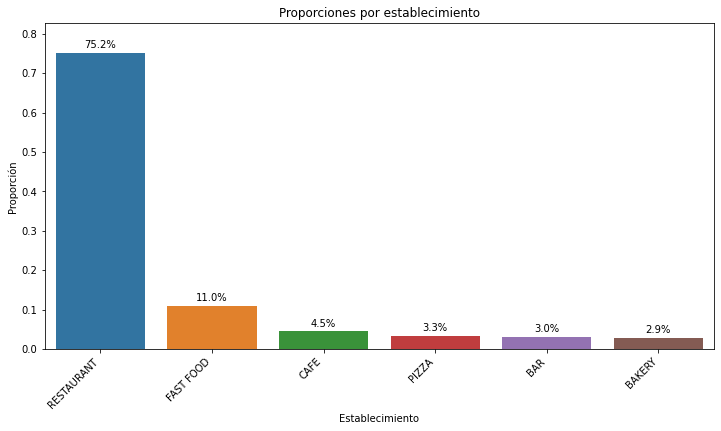

In [39]:
# Trazamos un gráfico de las proporciones de los tipos de establecimiento
f,ax = plt.subplots(figsize=(12,6))
ax = sns.barplot(data = proporcion_type, x='category', y='proportion',\
            order = proporcion_type.sort_values('proportion', ascending = False).category)



for rect in ax.patches:
   
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
  
    space = 3
     
    label = "{:.1%}".format(y_value)
   
    ax.annotate(
        label,                      
        (x_value, y_value),         
        xytext = (0, space),          
        textcoords = "offset points",
        ha = 'center',               
        va = 'bottom')     
plt.ylim(0, proporcion_type['proportion'].max()*1.1)
plt.title('Proporciones por establecimiento')
plt.ylabel('Proporción')
plt.xlabel('Establecimiento')
plt.xticks(rotation = 45, ha = 'right')
plt.show()

- Hay una gran cantidad de restaurantes establecidos en los L.A.
- Un establecimiento de café está en el tercer lugar con presencia en los L.A.
- fuente: datos abiertos sobre restaurantes en los L.A.

### Proporciones de los distintos tipos de establecimientos que pertenecen a una cadena. <a id='pdldtdeqpauc'></a>

In [40]:
# obtenemos las proporciones para cada tipo de establecimiento por cada cadena
proporcion_chain = rest_data[['object_type','chain']].value_counts(normalize=True).reset_index()
proporcion_chain.columns=['category','chain','proportion']
proporcion_chain

,category,chain,proportion
0,RESTAURANT,No pertenece,0.514247
1,RESTAURANT,Pertenece,0.237488
2,FAST FOOD,Pertenece,0.062688
3,FAST FOOD,No pertenece,0.047767
4,BAKERY,Pertenece,0.029323
5,CAFE,Pertenece,0.027562
6,BAR,No pertenece,0.022277
7,CAFE,No pertenece,0.017511
8,PIZZA,No pertenece,0.017304
9,PIZZA,Pertenece,0.015853


In [41]:
# obtenemos las proporciones de pertenencia a una cadena para el tipo de establecimiento 'Restaurant'
proporcion_coffee = rest_data.query("object_type == 'CAFE'")[['object_type','chain']].value_counts(normalize=True)
proporcion_coffee.map('{:.1%}'.format)

object_type  chain       
CAFE         Pertenece       61.1%
             No pertenece    38.9%
dtype: object

In [42]:
# obtenemos las proporciones de pertenencia a una cadena para el tipo de establecimiento 'Restaurant'
proporcion_rest = rest_data.query("object_type == 'RESTAURANT'")[['object_type','chain']].value_counts(normalize=True)
proporcion_rest.map('{:.1%}'.format)

object_type  chain       
RESTAURANT   No pertenece    68.4%
             Pertenece       31.6%
dtype: object

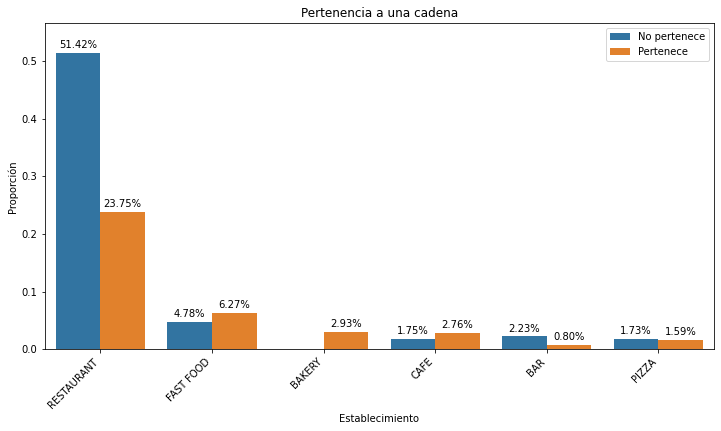

In [43]:
# Trazamos un gráfico de las proporciones de los tipos de establecimiento y su pertenencia a una cadena
f,ax = plt.subplots(figsize=(12,6))

#ordenamiento
order_1 = proporcion_chain[['category','proportion']].groupby('category').max().reset_index()

ax = sns.barplot(data = proporcion_chain, x= 'category', y= 'proportion', hue= 'chain',\
            order = order_1.sort_values('proportion', ascending= False).category)


for rect in ax.patches:
  
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2


    space = 3

    label = "{:.2%}".format(y_value)


    ax.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va='bottom')     
plt.ylim(0, proporcion_chain['proportion'].max()*1.1)
plt.title('Pertenencia a una cadena')
plt.ylabel('Proporción')
plt.xlabel('Establecimiento')
plt.xticks(rotation=45,ha='right')
plt.legend(loc='best')
plt.show()

- Aproximadamente el 70% de los restaurantes no pertenecen a una cadena comercial.
- Casi el 40% de los establecimientos de café no pertenecen a una cadena comercial.
- Casi el 60% de los fast food pertenecen a una cadena.
- Fuente: datos abiertos sobre restaurantes en los L.A.

### Tipos de establecimientos que es habitualmente una cadena. <a id='tdeqehuc'></a>

In [44]:
# veamos como se distribuye el número de asientos para los establecimientos que pertenecen a una cadena
rest_data.query("chain == 'Pertenece'")['number'].describe()

count    3676.000000
mean       39.694233
std        43.437212
min         1.000000
25%        13.000000
50%        25.000000
75%        44.000000
max       229.000000
Name: number, dtype: float64

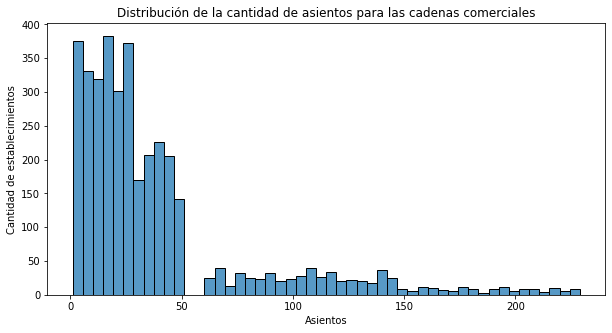

In [45]:
# tracemos un histograma para ver su distribución
f,ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(rest_data.query("chain == 'Pertenece'")['number'], bins=50)
plt.title('Distribución de la cantidad de asientos para las cadenas comerciales')
plt.xlabel('Asientos')
plt.ylabel('Cantidad de establecimientos')
plt.show()

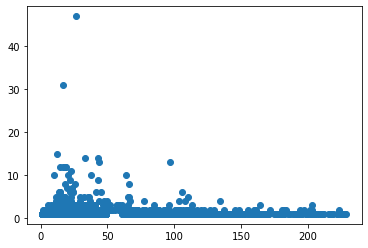

In [46]:
scatter = rest_data[rest_data['chain'] == "Pertenece"].groupby('object_name').agg({'number':'mean', 'object_name':'count'})
plt.scatter(scatter['number'], scatter['object_name']) 
plt.show()

- Con el grafico podemos notar que hay muchos establecimientos con hasta 50 asientos

### Promedio de asientos para cada tipo de establecimiento. <a id='pdapctde'></a>

In [47]:
# calculamos el promedio de asientos para cada tipo de establecimiento
mean_number = rest_data.pivot_table(index=['object_type', 'chain'], values= 'number', aggfunc= 'mean').reset_index()
mean_number

,object_type,chain,number
0,BAKERY,Pertenece,21.773852
1,BAR,No pertenece,46.381395
2,BAR,Pertenece,40.259740
3,CAFE,No pertenece,23.556213
4,CAFE,Pertenece,25.917293
5,FAST FOOD,No pertenece,23.633406
6,FAST FOOD,Pertenece,38.089256
7,PIZZA,No pertenece,31.143713
8,PIZZA,Pertenece,25.529412
9,RESTAURANT,No pertenece,49.513802


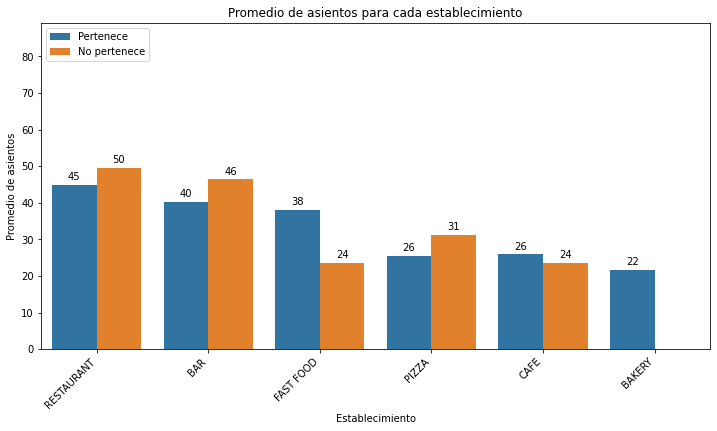

In [48]:
# Trazamos un gráfico del promedio de asientos para cada tipo de establecimiento
f,ax = plt.subplots(figsize=(12,6))

#ordenamiento
order_2 = mean_number[['object_type','number']].groupby('object_type').max().reset_index()
ax = sns.barplot(data = mean_number, x= 'object_type', y= 'number', hue= 'chain',\
              order = order_2.sort_values('number', ascending= False).object_type)
mean_coffee = mean_number[mean_number['object_type']=='CAFE']['number'].mean().round(0)
for rect in ax.patches:
    
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 3
    label = "{:.0f}".format(y_value)
    ax.annotate(
        label,                      
        (x_value, y_value),        
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va='bottom')     
plt.ylim(0, mean_number['number'].max()*1.8)
plt.title('Promedio de asientos para cada establecimiento')
plt.ylabel('Promedio de asientos')
plt.xlabel('Establecimiento')
plt.xticks(rotation=45,ha='right')
plt.legend(loc='best')
plt.show()


- El promedio de asientos para cada establecimiento es muy parecido, tanto si pertenecen a una cadena o no
- En promedio, un restaurant tiene la mayor cantidad de asientos, seguido de los bares.
- El promedio de asientos para un Cafe es de 25.0


### Diez mejores calles por número de establecimientos. <a id='dmcpnde'></a>

In [49]:
# agrupamos por nombre de la calle y extraemos las 10 calles con mayor numero de establecimientos
best_street = rest_data.groupby('street').agg(count_type= ('object_type','count'))\
                                .sort_values(by= ['count_type', 'street'], ascending=False)[0:10]
best_street

,count_type
street,
SUNSET,405
WILSHIRE,365
PICO,359
WESTERN,347
FIGUEROA,313
OLYMPIC,289
VERMONT,279
SANTA MONICA,251
HOLLYWOOD,246


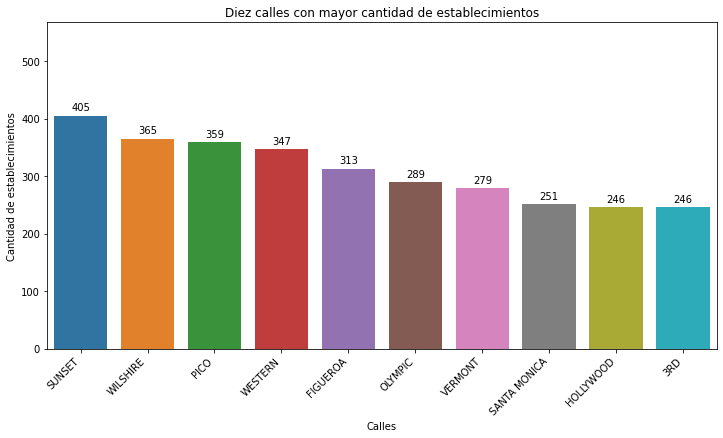

In [50]:
# Trazamos un gráfico para las diez calles con mayor numero de establecimiento
f,ax= plt.subplots(figsize= (12,6))
ax= sns.barplot(data= best_street, x= best_street.index, y= 'count_type')

for rect in ax.patches:
    
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 3
    label = "{:.0f}".format(y_value)

    ax.annotate(
        label,                      
        (x_value, y_value),        
        xytext= (0, space),          
        textcoords= "offset points", 
        ha= 'center',                
        va= 'bottom')     
plt.ylim(0, best_street['count_type'].max()*1.4)
plt.title('Diez calles con mayor cantidad de establecimientos')
plt.ylabel('Cantidad de establecimientos')
plt.xlabel('Calles')
plt.xticks(rotation= 45, ha= 'right')
plt.show()

Según lo realizado podemos observar que:
- **SUNSET, WILSHIRE y PICO** son las calles con mayor cantidad de establecimientos.
- **3RD** es la calle con la menor cantidad de establecimientos.

### Calles que tienen un solo establecimiento. <a id='eqtuse'></a>

In [51]:
# agrupamos por calle y contamos la cantidad de establecimientos
alone_street = rest_data.groupby('street').agg(count_type = ('object_type','count'))
alone_street.sample()

,count_type
street,
LA CIENGA,2


In [52]:
# contamos las calles con un solo establecimiento
alone_street[alone_street['count_type'] == 1].shape

(504, 1)

### Distribución del número de asientos para las calles con muchos establecimientos. <a id='ddndaplccme'></a>

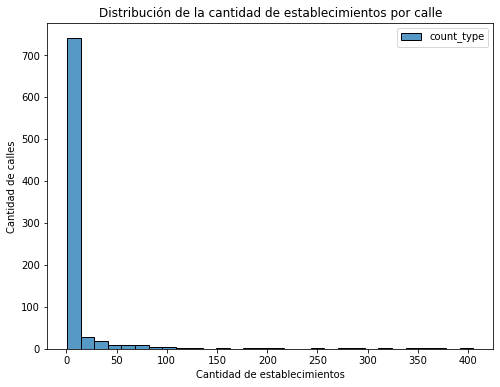

In [53]:
# creamos un histograma para observar la distribución del número de establecimientos por calle
plt.subplots(figsize= (8,6))
ax= sns.histplot(data= alone_street, bins=30)

plt.xlabel('Cantidad de establecimientos')
plt.ylabel('Cantidad de calles')
plt.title('Distribución de la cantidad de establecimientos por calle')
plt.show()

- Podemos observar que hay muchas calles con pocos establecimientos y pocas calles con muchos establecimientos.



In [54]:
# obtenemos los percentiles para la cantidad de establecimientos por calle
np.percentile(alone_street, [75,90,95,99,100]).round(0)

array([  3.,  22.,  57., 246., 405.])

- Podemos observar que el 75% de las calles tienen máximo tres establecimientos.
- El 90% tienen máximo veintidos establecimientos y el 95% tiene máximo cincuenta y siete establecimientos.
- Si una calle tiene más de 20 establecimientos estas calles sean consideradas con muchos establecimientos.

In [55]:
# obtengamos la lista de calles que tienen más de 22 establecimientos
list_street_20 = alone_street.query('count_type > 20').index
list_street_20

Index(['1ST', '2ND', '3RD', '4TH', '5TH', '6TH', '7TH', '8TH', '9TH', 'ADAMS',
       'ALAMEDA', 'ALVARADO', 'ATLANTIC', 'AVALON', 'BARRINGTON', 'BEVERLY',
       'BROADWAY', 'BROXTON', 'CAHUENGA', 'CENTINELA', 'CENTRAL', 'CENTURY',
       'CESAR  CHAVEZ', 'COLORADO', 'COMPTON', 'CRENSHAW', 'EAGLE ROCK',
       'EASTERN', 'ETH', 'FAIRFAX', 'FIGUEROA', 'FLORENCE', 'FLOWER',
       'FRANKLIN', 'GAYLEY', 'GLENDALE', 'GRAND', 'HIGHLAND', 'HILL',
       'HILLHURST', 'HOLLYWOOD', 'HOOVER', 'HOPE', 'HUNTINGTON', 'HYPERION',
       'JEFFERSON', 'LA BREA', 'LA CIENEGA', 'LARCHMONT', 'LINCOLN',
       'LOS ANGELES', 'LOS FELIZ', 'MAIN', 'MANCHESTER', 'MAPLE',
       'MARTIN LUTHER KING JR', 'MELROSE', 'MLK', 'NATIONAL', 'NORMANDIE',
       'OLYMPIC', 'PICO', 'ROBERTSON', 'SAN FERNANDO', 'SAN PEDRO',
       'SAN VICENTE', 'SANTA MONICA', 'SAWTELLE', 'SEPULVEDA', 'SLAUSON',
       'SOTO', 'SPRING', 'SUNSET', 'TEMPLE', 'VENICE', 'VERMONT', 'VERNON',
       'VINE', 'VIRGIL', 'WASHINGTON', 'WESTERN',

In [56]:
# usaremos la lista de calles y vamos a filtrar la data para obtener los datos de los establecimientos
street_data = rest_data[rest_data['street'].isin(list_street_20)]
street_data.head(5)

,id,object_name,address,chain,object_type,number,restaurant,street
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,No pertenece,CAFE,26,HABITAT COFFEE SHOP,EAGLE ROCK
1,11787,REILLY'S,100 WORLD WAY # 120,No pertenece,RESTAURANT,9,REILLY'S,WORLD WAY
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,No pertenece,FAST FOOD,20,STREET CHURROS,HOLLYWOOD
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,No pertenece,RESTAURANT,22,TRINITI ECHO PARK,SUNSET
5,11791,THE SPOT GRILL,10004 NATIONAL BLVD,No pertenece,RESTAURANT,14,THE SPOT GRILL,NATIONAL


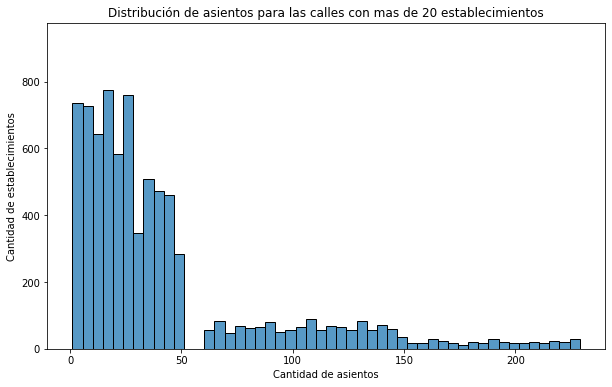

In [57]:
# creamos el gráfico de distribución de asientos para las calles con mas de 19 establecimientos
plt.subplots(figsize= (10,6))
ax= sns.histplot(street_data['number'], bins=50)
ylimit=ax.get_ylim()[1]*1.2
plt.ylim(0,ylimit)
plt.xlabel('Cantidad de asientos')
plt.ylabel('Cantidad de establecimientos')
plt.title('Distribución de asientos para las calles con mas de 20 establecimientos')
plt.show()


In [58]:
min_number = street_data['number'].min()
mean_number = street_data['number'].mean().astype(int)
max_number = street_data['number'].max()
print(f'Minimo de asientos: {min_number}')
print(f'Media de asientos: {mean_number}')
print(f'Maximo de asientos: {max_number}')
print(f'La cantidad de asientos por establecimiento va desde el: {min_number} hasta el {max_number} con un promedio de {mean_number}')

Minimo de asientos: 1
Media de asientos: 43
Maximo de asientos: 229
La cantidad de asientos por establecimiento va desde el: 1 hasta el 229 con un promedio de 43


In [59]:
# obtenemos los percentiles para la cantidad de asientos por establecimiento para calles con más de 20 establecimientos
np.percentile(street_data['number'],[50,75,90,95,99,100]).round(0)

array([ 27.,  46., 118., 145., 213., 229.])

In [60]:
# obtenemos los percentiles para la cantidad de asientos para establecimientos que venden 'Cafe'
np.percentile(street_data.query('object_type == "CAFE"')['number'],[50,75,90,95,99,100]).round(0)

array([ 20.,  33.,  44.,  48., 111., 143.])

In [61]:
# promedio de asientos para los establecimientos de 'Cafe', en calles con más de 20 establecimientos
street_data.query('object_type == "CAFE"')['number'].mean().round(0)

24.0

- En las calles con más de veinte establecimientos, el 50% de los establecimientos tienen hasta 27 asientos, el 75% hasta 46 y solo el 10% de los establecimientos tiene más de 117 asientos, hasta un máximo de 229.
- En las calles con más de veinte establecimientos, el 50% de los establecimientos de Cafe tienen hasta 20 asientos, el 75% hasta 32 y solo el 10% de los establecimientos tiene más de 44 asientos, hasta un máximo de 143. Con un promedio de 24.

### Las cafeterías en las diez calles con más establecimientos. <a id='lceldccme'></a>

In [62]:
# contamos la cantidad de cafeterias en las diez calles con mas establecimientos
count_coffee = rest_data[(rest_data['street'].isin(best_street.index)) & (rest_data['object_type'] == 'CAFE')]['street'].value_counts()
count_coffee.name = 'count_coffee'
count_coffee

SUNSET          28
WILSHIRE        22
HOLLYWOOD       13
PICO            12
SANTA MONICA    12
3RD             11
OLYMPIC         10
FIGUEROA        10
WESTERN          8
VERMONT          7
Name: count_coffee, dtype: int64

In [63]:

# unimos 'best_street' y 'count_coffee' para ver la proporcion de cafeterias
proporcion_coffee = best_street.merge(count_coffee, left_on = best_street.index, right_on= count_coffee.index)
proporcion_coffee.columns = ['street', 'count_type', 'count_coffee']

# obtenemos la proporcion de cafeterias respecto a la cantidad de establecimientos
proporcion_coffee['proporcion_coffee'] = proporcion_coffee['count_coffee']/proporcion_coffee['count_type']

# aplicamos formato de porcentaje
proporcion_coffee['proporcion_coffee'] = proporcion_coffee['proporcion_coffee'].map('{:.1%}'.format)
proporcion_coffee

,street,count_type,count_coffee,proporcion_coffee
0,SUNSET,405,28,6.9%
1,WILSHIRE,365,22,6.0%
2,PICO,359,12,3.3%
3,WESTERN,347,8,2.3%
4,FIGUEROA,313,10,3.2%
5,OLYMPIC,289,10,3.5%
6,VERMONT,279,7,2.5%
7,SANTA MONICA,251,12,4.8%
8,HOLLYWOOD,246,13,5.3%
9,3RD,246,11,4.5%


En la tabla anterior, podemos observar que la proporción de cafeterías existentes en las principales calles con más establecimientos es muy baja. Así que eso no puedes dar la oportunidad para poder establecer una cafetería en las calles con menor proporción de cafeterías y que son muy transitadas.

## Conclusión. <a id='ccs'></a>
- Hay una gran cantidad de restaurantes establecidos en los L.A., un 75%. Seguidos de establecimientos de comida rápida con un 11% y cafeterías con un 4.5%.
- Aproximadamente el 70% de los restaurantes no pertenecen a una cadena comercial.
- El 40% de los establecimientos de café no pertenecen a una cadena comercial.
- En una cadena comercial, hay muchos establecimientos con hasta 50 asientos, mientras que pocos establecimientos tienen más de 50 asientos.
- El promedio de asientos para cada establecimiento es muy parecido, tanto si pertenecen a una cadena o no.
- En promedio, un restaurant tiene la mayor cantidad de asientos con 47, seguido de los bares con 43 y, para una cafetería 25.
- Las cinco calles con mayor cantidad de establecimientos en los Angeles California, son: "SUNSET", "WILSHIRE", "PICO", "WESTERN" y "FIGUEROA".
- Hay 504 calles en Los Angeles, California, con un solo establecimiento.
- En las calles con más de 20 establecimientos, el 50% de los establecimientos tienen hasta 27 asientos, el 75% hasta 46 y solo el 10% de los establecimientos tiene más de 118 asientos, hasta un máximo de 229.
- En las calles con más de 20 establecimientos, el 50% de los establecimientos de Cafe tienen hasta 20 asientos, el 75% hasta 32 y solo el 10% de los establecimientos tiene más de 44 asientos, hasta un máximo de 143. Con un promedio de 24.
- La proporción de cafeterías existentes en las principales calles con más establecimientos es muy baja.

## Link de presentación. <a id='link'></a>

[link](https://drive.google.com/file/d/1T_1sH-_5rC7Olfxn7f9XG6e67OQqjCyJ/view?usp=drivesdk)